In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import agama

In [328]:
# Set the default font size for all text in the plot
plt.rcParams.update({'font.size': 18})

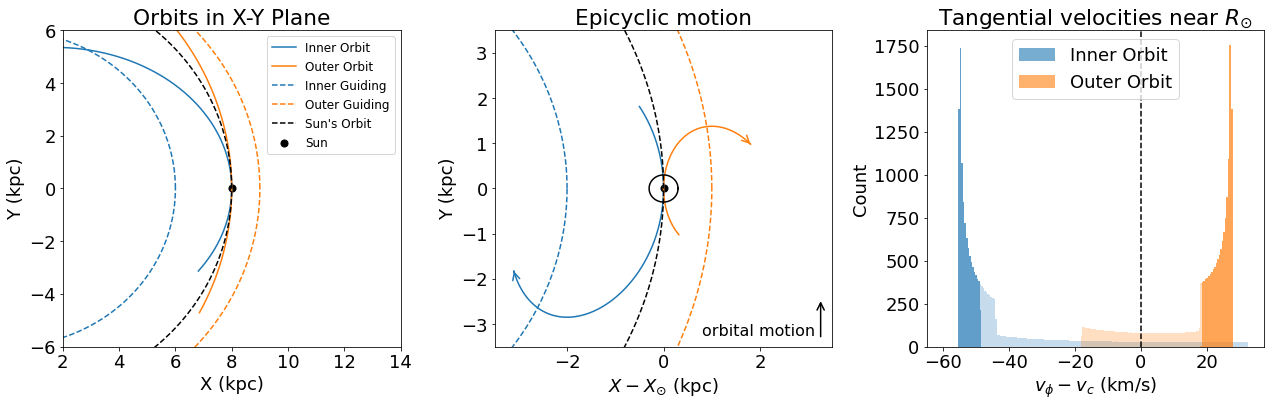

In [341]:
# Initialize AGAMA units (kpc, Msun, km/s)
agama.setUnits(length=1, mass=1, velocity=1)

# Constants
v_c = 220.0  # km/s, flat rotation speed
R0 = 8.0     # kpc, Sun's position
delta_R = 1 # kpc, radial increment

# Define the logarithmic potential
potential = agama.Potential(
    type='Logarithmic',
    v0=v_c,
    q=1.0  # Spherical potential
)

# Guiding radii
R_in = R0 - 2*delta_R  # Inner orbit guiding radius (6 kpc)
R_out = R0 + delta_R     # Outer orbit guiding radius (9 kpc)

# Angular rotation frequencies
Omega_in = v_c / R_in
Omega_out = v_c / R_out

# Initial positions (at R0, phi=0)
x0 = R0
y0 = 0.0
z0 = 0.0

# Radial velocities at apocenter/pericenter are zero
v_R_in = 0.0
v_R_out = 0.0

# Azimuthal velocities at R0
L_in = R_in * v_c
L_out = R_out * v_c
v_phi_in = L_in / R0
v_phi_out = L_out / R0

# Convert velocities to Cartesian coordinates
phi0 = 0.0  # At phi = 0
v_x_in = v_R_in
v_y_in = v_phi_in
v_z_in = 0.0

v_x_out = v_R_out
v_y_out = v_phi_out
v_z_out = 0.0

# Initial conditions
ic_in = [x0, y0, z0, v_x_in, v_y_in, v_z_in]
ic_out = [x0, y0, z0, v_x_out, v_y_out, v_z_out]

# Time parameters
t_max = 0.04 # Gyr
n_steps = 10000  # Number of steps for each integration

# Inner orbit integration backward in time
orbit_in_backward = agama.orbit(
    ic=ic_in,
    potential=potential,
    time=-0.5*t_max,
    timestart=1e-6,
    trajsize=n_steps
)

# Inner orbit integration forward in time
orbit_in_forward = agama.orbit(
    ic=ic_in,
    potential=potential,
    time=1.5*t_max,
    timestart=0,
    trajsize=n_steps
)

# Combine backward and forward trajectories for inner orbit
trajectory_in = np.vstack((orbit_in_backward[1][::-1], orbit_in_forward[1][1:]))
times_in = np.concatenate((orbit_in_backward[0][::-1], orbit_in_forward[0][1:]))

# Outer orbit integration backward in time
orbit_out_backward = agama.orbit(
    ic=ic_out,
    potential=potential,
    time=-0.5*t_max,
    timestart=1e-6,
    trajsize=n_steps
)

# Outer orbit integration forward in time
orbit_out_forward = agama.orbit(
    ic=ic_out,
    potential=potential,
    time=1.5*t_max,
    timestart=0,
    trajsize=n_steps
)

# Combine backward and forward trajectories for outer orbit
trajectory_out = np.vstack((orbit_out_backward[1][::-1], orbit_out_forward[1][1:]))
times_out = np.concatenate((orbit_out_backward[0][::-1], orbit_out_forward[0][1:]))

# Extract trajectory data for the inner orbit
x_in = trajectory_in[:, 0]
y_in = trajectory_in[:, 1]
z_in = trajectory_in[:, 2]
v_x_in = trajectory_in[:, 3]
v_y_in = trajectory_in[:, 4]
v_z_in = trajectory_in[:, 5]

# Extract trajectory data for the outer orbit
x_out = trajectory_out[:, 0]
y_out = trajectory_out[:, 1]
z_out = trajectory_out[:, 2]
v_x_out = trajectory_out[:, 3]
v_y_out = trajectory_out[:, 4]
v_z_out = trajectory_out[:, 5]

# Compute radial positions and angular positions
r_in = np.sqrt(x_in**2 + y_in**2)
r_out = np.sqrt(x_out**2 + y_out**2)
phi_in = np.unwrap(np.arctan2(y_in, x_in))
phi_out = np.unwrap(np.arctan2(y_out, x_out))

# Compute phase offsets for each orbit
w0 = np.where(np.abs(times_in) == min(np.abs(times_in)))[0] 
phi_in0 = phi_in[w0]+Omega_in*times_in[0]
w0 = np.where(np.abs(times_out) == min(np.abs(times_out)))[0] 
phi_out0 = phi_out[w0]+Omega_out*times_in[0]

# Compute guiding center angular position
phi_g_in = phi_in0 + Omega_in * (times_in-times_in[0])
phi_g_out = phi_out0 + Omega_out * (times_out-times_out[0])

# Compute x(t) and y(t) in epicyclic coordinates
x_epi_in = R_in * (phi_in - phi_g_in)
y_epi_in = r_in - R_in
x_epi_out = R_out * (phi_out - phi_g_out)
y_epi_out = r_out - R_out

# Compute v_phi for both orbits
v_phi_in = (x_in * v_y_in - y_in * v_x_in) / r_in
v_phi_out = (x_out * v_y_out - y_out * v_x_out) / r_out

# Tangential velocities near R = R0
tolerance = 0.3  # kpc
indices_in = np.where(np.abs(r_in - R0) < tolerance)[0]
indices_out = np.where(np.abs(r_out - R0) < tolerance)[0]

v_phi_in_near_R0 = v_phi_in[indices_in]
v_phi_out_near_R0 = v_phi_out[indices_out]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Guiding radii
theta_sun = np.linspace(0, 2 * np.pi, 1000)
x_sun_circle = R0 * np.cos(theta_sun)
y_sun_circle = R0 * np.sin(theta_sun)
x_in_circle = R_in * np.cos(theta_sun)
y_in_circle = R_in * np.sin(theta_sun)
x_out_circle = R_out * np.cos(theta_sun)
y_out_circle = R_out * np.sin(theta_sun)

# Panel 1: Orbits in the X-Y plane
axs[0].plot(x_in, y_in, color='tab:blue', label='Inner Orbit')
axs[0].plot(x_out, y_out, color='tab:orange', label='Outer Orbit')

axs[0].plot(x_in_circle, y_in_circle, linestyle='--', color='tab:blue', label='Inner Guiding')
axs[0].plot(x_out_circle, y_out_circle, linestyle='--', color='tab:orange', label='Outer Guiding')

# Sun's orbit (assumed circular)
theta_sun = np.linspace(0, 2 * np.pi, 1000)
axs[0].plot(R0 * np.cos(theta_sun), R0 * np.sin(theta_sun), 'k--', label='Sun\'s Orbit')
axs[0].scatter([x0], [y0], color='k', marker='o', s=50, label='Sun')
axs[0].set_xlabel('X (kpc)')
axs[0].set_ylabel('Y (kpc)')

axs[0].set_xlim(R0 - 6*delta_R, R0 + 6 * delta_R)
axs[0].set_ylim(-6 * delta_R, 6 * delta_R)
axs[0].legend(fontsize=12)
axs[0].set_title('Orbits in X-Y Plane')

# Panel 2: Epicyclic Ellipses
axs[1].plot(y_epi_in+(R_in-R0), x_epi_in, color='tab:blue', label='Inner Epicycle')
axs[1].plot(y_epi_out+(R_out-R0), x_epi_out, color='tab:orange', label='Outer Epicycle')

# Adding arrows to indicate the direction of the curves
arrowprops = dict(arrowstyle='->', color='tab:blue', lw=1.5)
axs[1].annotate('', 
                xy=(y_epi_in[-1] + (R_in - R0), x_epi_in[-1]), 
                xytext=(y_epi_in[-2] + (R_in - R0), x_epi_in[-2]), 
                arrowprops=arrowprops)

arrowprops = dict(arrowstyle='->', color='tab:orange', lw=1.5)
axs[1].annotate('', 
                xy=(y_epi_out[-1] + (R_out - R0), x_epi_out[-1]), 
                xytext=(y_epi_out[-2] + (R_out - R0), x_epi_out[-2]), 
                arrowprops=arrowprops)

axs[1].set_xlabel(r'$X-X_{\odot}$ (kpc)')
axs[1].set_ylabel('Y (kpc)')
axs[1].set_xlim(-3.5 * delta_R, 3.5 * delta_R)
axs[1].set_ylim(-3.5 * delta_R, 3.5 * delta_R)

# Plot the guiding radii and the Sun's orbit
axs[1].plot(x_sun_circle-R0, y_sun_circle, linestyle='--', color='black', label='Sun\'s Orbit')
axs[1].plot(x_in_circle-R0, y_in_circle, linestyle='--', color='tab:blue', label='Inner Guiding')
axs[1].plot(x_out_circle-R0, y_out_circle, linestyle='--', color='tab:orange', label='Outer Guiding')

x_sun_nei = tolerance * np.cos(theta_sun)
y_sun_nei = tolerance * np.sin(theta_sun)
axs[1].plot(x_sun_nei, y_sun_nei, color='black')

# Add a small vertical arrow in the bottom right corner with text "Orbital motion"
arrowprops_vertical = dict(arrowstyle='->', color='black', lw=1.5)
x0 = axs[1].get_xlim()[1]
y0 = axs[1].get_ylim()[0]
axs[1].annotate('', 
                xy=(0.93*x0, 0.7 * y0 ),  # Arrow points upward
                xytext=(0.93*x0, 0.95 * y0 ),  # Text position
                arrowprops=arrowprops_vertical)

# Add text
axs[1].text(0.9*x0, 0.95 * y0, 'orbital motion', ha='right', va='bottom', fontsize=16)
axs[1].scatter([0], [0], color='k', marker='o', s=50)
axs[1].set_title('Epicyclic motion')

# Panel 3: Tangential Velocity Distributions
min_v = min(np.min(v_phi_in_near_R0 - v_c), np.min(v_phi_out_near_R0 - v_c))
max_v = max(np.max(v_phi_in_near_R0 - v_c), np.max(v_phi_out_near_R0 - v_c))
bins = np.linspace(min_v - 5, max_v + 5, 200)

axs[2].hist(v_phi_in_near_R0 - v_c, bins=bins, alpha=0.6, color='tab:blue', label='Inner Orbit')
axs[2].hist(v_phi_in - v_c, bins=bins, color='tab:blue', alpha =0.25)
axs[2].hist(v_phi_out_near_R0 - v_c, bins=bins, alpha=0.6, color='tab:orange', label='Outer Orbit')
axs[2].hist(v_phi_out - v_c, bins=bins, alpha=0.25, color='tab:orange')

axs[2].axvline(0, color='black', linestyle='--')  

axs[2].set_xlabel(r'$v_{\phi}-v_c$ (km/s)')
axs[2].set_ylabel('Count')
axs[2].legend(loc='upper center')
axs[2].set_title(r'Tangential velocities near $R_{\odot}$')
axs[2].set_xlim(min_v - 10, max_v + 10)

plt.tight_layout()

plt.savefig("../Figures/asymmetric_drift.png", format="png", dpi=300, 
            facecolor='white', bbox_inches='tight')

plt.show()